In [1]:
# https://youtu.be/tepxdcepTbY
"""
@author: J3viton
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""


'\n@author: J3viton\nCode tested on Tensorflow: 2.2.0\n    Keras: 2.4.3\ndataset: https://finance.yahoo.com/quote/GE/history/\nAlso try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC\n'

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
import seaborn as sns

In [3]:
#Read the csv file
#df = pd.read_csv('GE.csv')
df= pd.read_csv('telefonica_01.csv')    ### 'rovi_05.csv''zara_02.csv'telefonica_01.csv
print(df.tail()) #7 columns, including the Date. 


            Date  position  Close      hull    EMA_50   EMA_100    EMA_30  \
4123  2022-12-01      4123  3.638  3.621884  3.606467  3.790773  3.564488   
4124  2022-12-02      4124  3.580  3.623017  3.605429  3.786600  3.565488   
4125  2022-12-05      4125  3.535  3.614558  3.602667  3.781618  3.563521   
4126  2022-12-06      4126  3.577  3.604316  3.601660  3.777566  3.564391   
4127  2022-12-07      4127  3.508  3.586189  3.597987  3.772228  3.560753   

      positionnn  
4123        4123  
4124        4124  
4125        4125  
4126        4126  
4127        4127  


#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(5)) #Check last few dates. 

In [4]:
df.shape

(4128, 8)

In [5]:
#Variables for training
cols = list(df)[2:7]  #df.columns.tolist()
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Close', 'hull', 'EMA_50', 'EMA_100', 'EMA_30']


In [6]:
cols[0]

'Close'

In [7]:
hull_col=1

<AxesSubplot:>

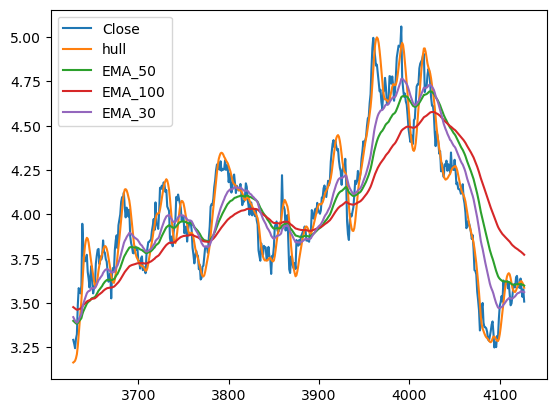

In [8]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(500)
df_for_plot.plot.line()

In [9]:
### ESTUDIA como funciona este tema del scaler... deberia ser entre 0 y 1, no?

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#Estándariza los datos eliminando la media y escalando los datos de forma que su varianza sea igual a 1.

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled


array([[ 0.54139238,  0.5245039 ,  0.42592324,  0.38768986,  0.4491768 ],
       [ 0.54342093,  0.53139647,  0.43039287,  0.39064003,  0.45512102],
       [ 0.56573488,  0.54082953,  0.43557567,  0.39398724,  0.46213446],
       ...,
       [-1.55094601, -1.53396873, -1.57242573, -1.56995922, -1.56622983],
       [-1.54232858, -1.53606876, -1.57263541, -1.57081614, -1.56604978],
       [-1.55648585, -1.53978556, -1.57340056, -1.57194506, -1.56680305]])

In [10]:
df_for_training_scaled.shape


(4128, 5)

df_data = pd.DataFrame(df_for_training_scaled ,columns = ['close','hull','50','100','30'])
df_data.to_excel("telefonica_scaled.xlsx", 
          index=True,
          sheet_name="data")

In [11]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainXX = []
trainYY = []
trainX_test=[]

n_future = 2   # origina=1,   Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.  FILAS

In [12]:

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    ## en este caso Append añade un elemento que es un array de dos dimensiones.
    trainXX.append( df_for_training_scaled[ i - n_past : i ,  0:df_for_training.shape[1]])  #n_past filas X 5 columnas (feautures)
    #slicing: fila desde (i-n_past) hasta i///// Columna desde 0: 5 =>(df_for_training.shape[1])
    
    trainYY.append(df_for_training_scaled[i + n_future - 1:i + n_future, hull_col])  ##[17:18,0] un posicoin de la fila para la columna 0
    ### el 4 es la caracteritica elegida Close//EMA//EMA100//


## separar Training y TEST

In [13]:
trainX, trainX_test, trainY, trainY_test  = train_test_split(trainXX, trainYY, test_size = 0.10,shuffle = False)


trainX_test[-1,-1, hull_col]

trainY_test[-1]

In [14]:

trainX, trainY = np.array(trainX), np.array(trainY)
trainX_test, trainY_test = np.array(trainX_test), np.array(trainY_test)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('trainX_test shape == {}.'.format(trainX_test.shape))

"""
tenemos un array de 238 elementos en el que cada elemento es un array de 14x5
"""

trainX shape == (3701, 14, 5).
trainY shape == (3701, 1).
trainX_test shape == (412, 14, 5).


'\ntenemos un array de 238 elementos en el que cada elemento es un array de 14x5\n'

trainX_test

trainX[0][13][4]

df_data = pd.DataFrame(trainX[-1,-14:,hull_col], columns = ['hull'])
df_data.to_excel("telefonica_010.xlsx", 
          index=True,
          sheet_name="data")


In [15]:
#trainX[-1,-14:,hull_col]
trainX[-1,-n_past:,hull_col]  # cogemos el ultimo tramo de datos del grupo n_past


array([-1.50864257, -1.51063484, -1.51307201, -1.51435491, -1.51430927,
       -1.51522507, -1.51641357, -1.51803127, -1.52016101, -1.51986299,
       -1.51704546, -1.51191975, -1.50565673, -1.49940699])

In [16]:
trainY[-1]

array([-1.48735531])

In [17]:

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
197/197 [==============================] - 9s 26ms/step - loss: 0.0568 - val_loss: 0.0037
Epoch 2/30
197/197 [==============================] - 4s 21ms/step - loss: 0.0158

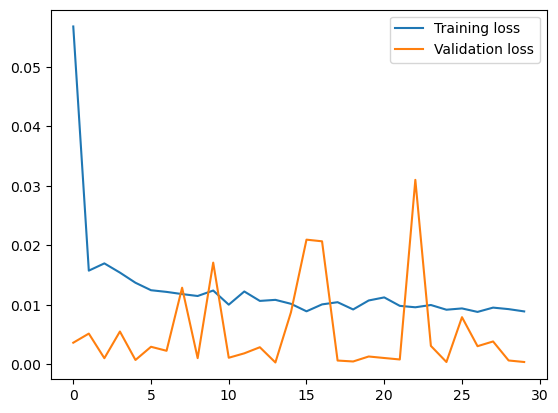

In [18]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) #64
model.add(LSTM(64, activation='relu', return_sequences=False))   #32
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.15, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [19]:

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
#from pandas.tseries.holiday import USFederalHolidayCalendar
#from pandas.tseries.offsets import CustomBusinessDay

#us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.


##n_days_for_prediction=10  #let us predict past 15 days

##predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_past, freq='D').tolist()
##print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[0:n_past])
#prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
                                                            # desde -n hasta el final. Cada elemento es un array bidimensional
#Pido una predcicion para un array de fechas, me devuelve la predicion para cada una

#Nos vamos n_daysforPredcition atras y calculamos la precidion a n_future (6) days despues.

1/1 [==============================] - 1s 641ms/step


In [20]:
#print (trainX[-2:])  # dos ultimos elementos. Cada elemento es un array de 15x5
print (prediction)

[[0.78667796]
 [0.81209195]
 [0.8334607 ]
 [0.8484192 ]
 [0.857002  ]
 [0.87565553]
 [0.89612794]
 [0.909248  ]
 [0.9234066 ]
 [0.9099456 ]
 [0.89967084]
 [0.90011644]
 [0.90960264]
 [0.92808676]]


In [21]:
trainY[-n_past+n_future:]

array([[-1.51430927],
       [-1.51522507],
       [-1.51641357],
       [-1.51803127],
       [-1.52016101],
       [-1.51986299],
       [-1.51704546],
       [-1.51191975],
       [-1.50565673],
       [-1.49940699],
       [-1.49361746],
       [-1.48735531]])

In [22]:
xx=(range(n_past))

pred= prediction
pred.shape = (n_past)
real=trainY[-n_past:]
real.shape = (n_past)

#sns.lineplot(x=xx, y=pred, color='lightgreen')
#sns.lineplot(x=xx, y=real)

real

In [23]:
pred

array([0.78667796, 0.81209195, 0.8334607 , 0.8484192 , 0.857002  ,
       0.87565553, 0.89612794, 0.909248  , 0.9234066 , 0.9099456 ,
       0.89967084, 0.90011644, 0.90960264, 0.92808676], dtype=float32)

trainX.shape

### VISUALIZAION DATOS TEST  (esto no son lo datos de test, TrainX_test deberia ser)

pred_gap = np.zeros(n_past+n_future)
muestra_gap =[]
xx=[]

muestreo=50  # minimo 20
gapmuestras=np.zeros(muestreo-n_past)
gapprevion=np.zeros(n_future)
gappostprevison= np.zeros(muestreo-n_future-n_past)

for ii in range (len(gapmuestras)):
    gapmuestras[ii] = np.nan
for ii in range (len(gapprevion)):
    gapprevion[ii] = np.nan
for ii in range (len(gappostprevison)):
    gappostprevison[ii] = np.nan 
for ii in range (len(pred_gap)):
    pred_gap[ii] = np.nan      


inicio= np.zeros(n_future+n_past)    

origen=n_past+n_future


for i in range(n_past, len(trainX)-100, muestreo):
    
    prediction = model.predict(trainX[i-n_past:i])
    prediction.shape = (n_past)   #me devuleve 15//n_past previsiones a 6//n_future dias vista
    pred_gap=np.concatenate((pred_gap, prediction), axis=0)  #predcicion son n_past... en un futuro de n_futre muestras
    pred_gap=np.concatenate((pred_gap, gapmuestras), axis=0)

    ##xx=(trainX[i-n_past:i,0,hull_col])
    xx=(trainX[i-n_past,-n_past:,hull_col])
    
    ##xx= trainXX[-1:, -n_past:, hull_col]  # coje el ultimo tramo de datos 
    xx.shape = ( n_past)
    
    muestra_gap=np.concatenate((muestra_gap, xx  ), axis=0)
    muestra_gap=np.concatenate((muestra_gap, gapmuestras), axis=0)

    #print(trainX[i:i+n_days_for_prediction])
    ##print(xx)
    #fake =input()


%matplotlib notebook

trainX_test.shape


#sns.lineplot(y=pred_gap, color='lightgreen')

yy2y=trainX[0:(len(trainX)),0,0]
#yy2y.shape = (len(df_for_training_scaled[0]) )
plt.plot(yy2y, label='curva Close',color='lightblue')

yyy=trainX[0:(len(trainX)),0,hull_col]        ## yyy=trainXX[-1:,-n_past:,hull_col]    



"""
##xx=(trainX[i-n_past:i,0,hull_col])
xx=(trainX[i-n_past,-n_past:,hull_col])

##xx= trainXX[-1:, -n_past:, hull_col]  # coje el ultimo tramo de datos 
xx.shape = ( n_past)
////////////////////
"""

#yyy.shape = (df_for_training_scaled.shape[0] )
plt.plot(yyy, label='curva REAL',color='pink')

plt.plot(muestra_gap, color='red',label='datos origen Prediccion')
plt.plot(pred_gap, color='lightgreen', label='Predicción')



plt.legend()
plt.show()

In [24]:
#plt.savefig('lstm3.jpg',dpi=600)

In [25]:
##k=input()

### mostramos los Datos de TEST


In [26]:
df.tail()


,Date,position,Close,hull,EMA_50,EMA_100,EMA_30,positionnn
4123,2022-12-01,4123,3.638,3.621884,3.606467,3.790773,3.564488,4123
4124,2022-12-02,4124,3.580,3.623017,3.605429,3.786600,3.565488,4124
4125,2022-12-05,4125,3.535,3.614558,3.602667,3.781618,3.563521,4125
4126,2022-12-06,4126,3.577,3.604316,3.601660,3.777566,3.564391,4126
4127,2022-12-07,4127,3.508,3.586189,3.597987,3.772228,3.560753,4127


In [27]:
pred_gapp = np.zeros(n_past+n_future)
muestra_gapp =[]
xx=[]

muestreo=20  # minimo 20
gapmuestras=np.zeros(muestreo-n_past)
gapprevion=np.zeros(n_future)
gappostprevison= np.zeros(muestreo-n_future-n_past)

for ii in range (len(gapmuestras)):
    gapmuestras[ii] = np.nan
for ii in range (len(gapprevion)):
    gapprevion[ii] = np.nan
for ii in range (len(gappostprevison)):
    gappostprevison[ii] = np.nan 
for ii in range (len(pred_gapp)):
    pred_gapp[ii] = np.nan      


##inicio= np.zeros(n_future+n_past)    
##origen=n_past+n_future


for i in range(len(trainX_test)-200, len(trainX_test), muestreo):
    
    prediction = model.predict(trainX_test[i-n_past:i])
    prediction.shape = (n_past)   #me devuleve 15//n_past previsiones a 6//n_future dias vista
    pred_gapp=np.concatenate((pred_gapp, prediction), axis=0)  #predcicion son n_past... en un futuro de n_futre muestras
    pred_gapp=np.concatenate((pred_gapp, gapmuestras), axis=0)

    ## MAL   xx=(trainX_test[i-n_past:i,0,hull_col])
    xx=(trainX_test[i-n_past,-n_past:,hull_col])
    
    ## MAL xx=(trainXX[-n_past:,0,hull_col]) ## Mal porque coje el primer elemento de cada uno de los tramos... parecido pero mal
    ##xx= trainXX[-1:, -n_past:, hull_col]  # coje el ultimo tramo de datos 
    xx.shape = ( n_past)
    

    
    muestra_gapp=np.concatenate((muestra_gapp, xx  ), axis=0)
    muestra_gapp=np.concatenate((muestra_gapp, gapmuestras), axis=0)
   


1/1 [==============================] - 0s 38ms/step


In [28]:
### len(trainX_test)  # 1233
##prediction
trainX_test[1233-n_past:1233, -1, hull_col]

array([], dtype=float64)

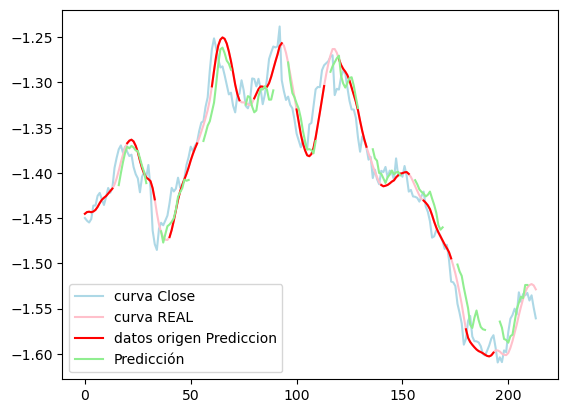

In [29]:
yy2y=trainX_test[len(trainX_test)-200-14:(len(trainX_test)),0,0]
            #yy2y.shape = (len(df_for_training_scaled[0]) )
plt.plot(yy2y, label='curva Close',color='lightblue')

yyy=trainX_test[len(trainX_test)-200-14:(len(trainX_test)),0,hull_col]
            #yyy.shape = (df_for_training_scaled.shape[0] )
plt.plot(yyy, label='curva REAL',color='pink')

plt.plot(muestra_gapp, color='red',label='datos origen Prediccion')
plt.plot(pred_gapp, color='lightgreen', label='Predicción')



plt.legend()
plt.show()

## Preparo los datos para la predicción final

In [30]:
for i in range(n_past, len(df_for_training_scaled) ):
    ## en este caso Append añade un elemento que es un array de dos dimensiones.
    trainXX.append( df_for_training_scaled[ i - n_past : i ,  0:df_for_training.shape[1]]) 
trainXX = np.array(trainXX)
    
pred_gapp = np.zeros(n_past+n_future)
muestra_gapp =[]
xx=[]

muestreo=30  # minimo 20
gapmuestras=np.zeros(muestreo-n_past)
gapprevion=np.zeros(n_future)
gappostprevison= np.zeros(muestreo-n_future-n_past)

for ii in range (len(gapmuestras)):
    gapmuestras[ii] = np.nan
for ii in range (len(gapprevion)):
    gapprevion[ii] = np.nan
for ii in range (len(gappostprevison)):
    gappostprevison[ii] = np.nan  
for ii in range (len(pred_gapp)):
    pred_gapp[ii] = np.nan  

prediction = model.predict(trainXX[-n_past:])
prediction.shape = (n_past)   #me devuleve 14//n_past previsiones a 6//n_future dias vista desde la ultima referencia
pred_gapp=np.concatenate((pred_gapp, prediction), axis=0)  #predcicion son n_past... en un futuro de n_futre muestras
pred_gapp=np.concatenate((pred_gapp, gapmuestras), axis=0)

## MAL xx=(trainXX[-n_past:,0,hull_col]) ## Mal porque coje el primer elemento de cada uno de los tramos... parecido pero mal
xx= trainXX[-1:, -n_past:, hull_col]  # coje el ultimo tramo de datos 
xx.shape = ( n_past)
muestra_gapp=np.concatenate((muestra_gapp, xx  ), axis=0)
muestra_gapp=np.concatenate((muestra_gapp, gapmuestras), axis=0)



1/1 [==============================] - 0s 53ms/step


%matplotlib widget

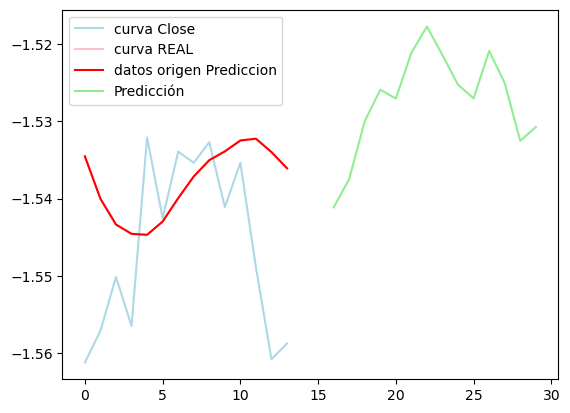

In [31]:
##Plot
yy2y=trainXX[-n_past:(len(trainXX)),0,0]
            #yy2y.shape = (len(df_for_training_scaled[0]) )
plt.plot(yy2y, label='curva Close',color='lightblue')


yyy=trainXX[-1:,-n_past:,hull_col]                    ###
yyy.shape = ( n_past)
plt.plot(yyy, label='curva REAL',color='pink')

plt.plot(muestra_gapp, color='red',label='datos origen Prediccion')
plt.plot(pred_gapp, color='lightgreen', label='Predicción')



plt.legend()
plt.show()

In [32]:
df.tail()

,Date,position,Close,hull,EMA_50,EMA_100,EMA_30,positionnn
4123,2022-12-01,4123,3.638,3.621884,3.606467,3.790773,3.564488,4123
4124,2022-12-02,4124,3.580,3.623017,3.605429,3.786600,3.565488,4124
4125,2022-12-05,4125,3.535,3.614558,3.602667,3.781618,3.563521,4125
4126,2022-12-06,4126,3.577,3.604316,3.601660,3.777566,3.564391,4126
4127,2022-12-07,4127,3.508,3.586189,3.597987,3.772228,3.560753,4127


In [33]:
trainXX[-1:,-1,2]

array([-1.57263541])

In [34]:
trainXX[-1:, -n_past:, hull_col]

array([[-1.5345219 , -1.54001583, -1.54334365, -1.54455389, -1.54467687,
        -1.54296335, -1.53993903, -1.53712573, -1.53501638, -1.53387868,
        -1.53246654, -1.53223427, -1.53396873, -1.53606876]])

In [35]:
trainXX[-n_past:(len(trainXX)),0,hull_col]  #mall

array([-1.59352506, -1.5858575 , -1.57658058, -1.56774297, -1.55736145,
       -1.54795265, -1.53922729, -1.53209005, -1.52676074, -1.52405075,
       -1.52294013, -1.52437151, -1.52874912, -1.5345219 ])

In [36]:
prediction

array([-1.5411288, -1.537438 , -1.529965 , -1.5258955, -1.5270354,
       -1.5211116, -1.5177077, -1.5214394, -1.5252537, -1.5270128,
       -1.5208759, -1.525035 , -1.532513 , -1.5307314], dtype=float32)

In [37]:
#trainXX[-n_past:]

In [38]:
## Save model
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/